In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'bokaro.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
pulling from cache
loading from ../../misc/cache/dataframes_ts_27102020_tracker.pkl
splitting data ..
splitting data ..
          date      state        district  total  active  recovered  deceased  \
0   2020-07-05  Jharkhand  East Singhbhum    505     257        246         2   
1   2020-07-06  Jharkhand  East Singhbhum    517     263        252         2   
2   2020-07-07  Jharkhand  East Singhbhum    573     319        252         2   
3   2020-07-08  Jharkhand  East Singhbhum    592     311        279         2   
4   2020-07-09  Jharkhand  East Singhbhum    620     339        279         2   
..         ...        ...             ...    ...     ...        ...       ...   
109 2020-10-22  Jharkhand  East Singhbhum  15896    1323      14247       326   
110 2020-10-23  Jharkhand  East Singhbhum  15932    1307      14297       328   
111 2020-10-24  Jharkhand  East Singhbhum  15980    1312      14340       328   
112 2020-10-25  Jharkhand  East Singhbhum  16011 

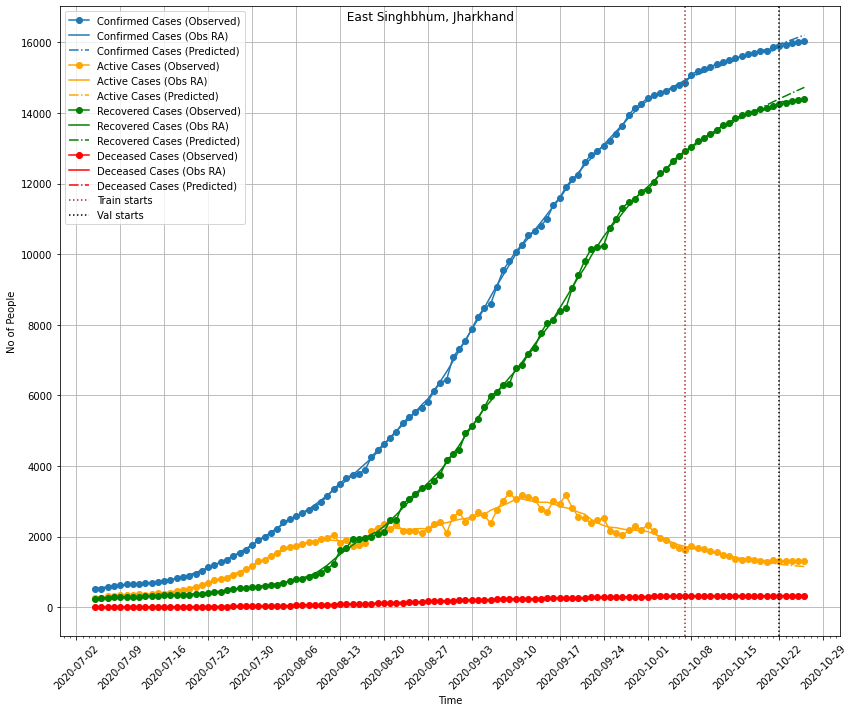

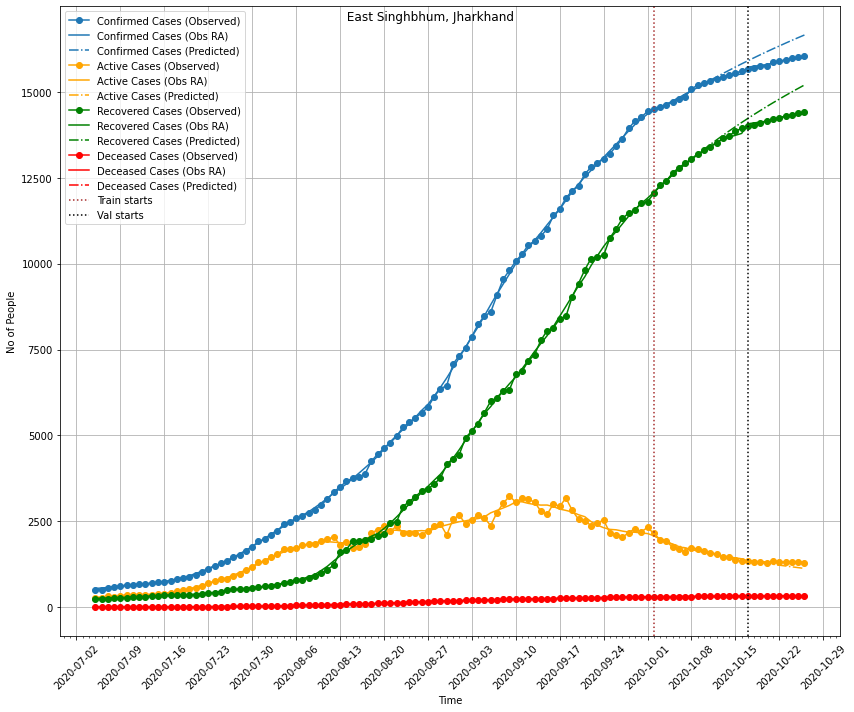

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 10
m2_params['split']['test_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)
# predictions_dict['m2'] = predictions_dict['m1']

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.11470707174821303,
 'I_hosp_ratio': 0.1814028662793296,
 'P_fatal': 0.014661433688692792,
 'T_inc': 4.902474120651393,
 'T_inf': 3.369352050994292,
 'T_recov': 14.154459517315047,
 'T_recov_fatal': 27.77328582944127,
 'lockdown_R0': 1.0636102875810807}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.3081460647044334,
 'I_hosp_ratio': 0.10789075881299431,
 'P_fatal': 0.008888263765796569,
 'T_inc': 4.557699415924231,
 'T_inf': 3.256179246884636,
 'T_recov': 11.34440920522594,
 'T_recov_fatal': 20.40965923767796,
 'lockdown_R0': 0.8927856722385195}

## Loss Dataframes

### M1 Loss DataFrame

In [9]:
predictions_dict['m1']['df_loss']

train       val
total      0.380697  0.666595
active      2.48927   9.56298
recovered  0.401749   1.62677
deceased   0.354241   0.48579

### M2 Loss DataFrame

In [10]:
predictions_dict['m2']['df_loss']

train      val
total      0.447894  2.70834
active      2.82461  5.95965
recovered  0.467736  3.59519
deceased    1.23015  1.74522

## Sensitivity Plot

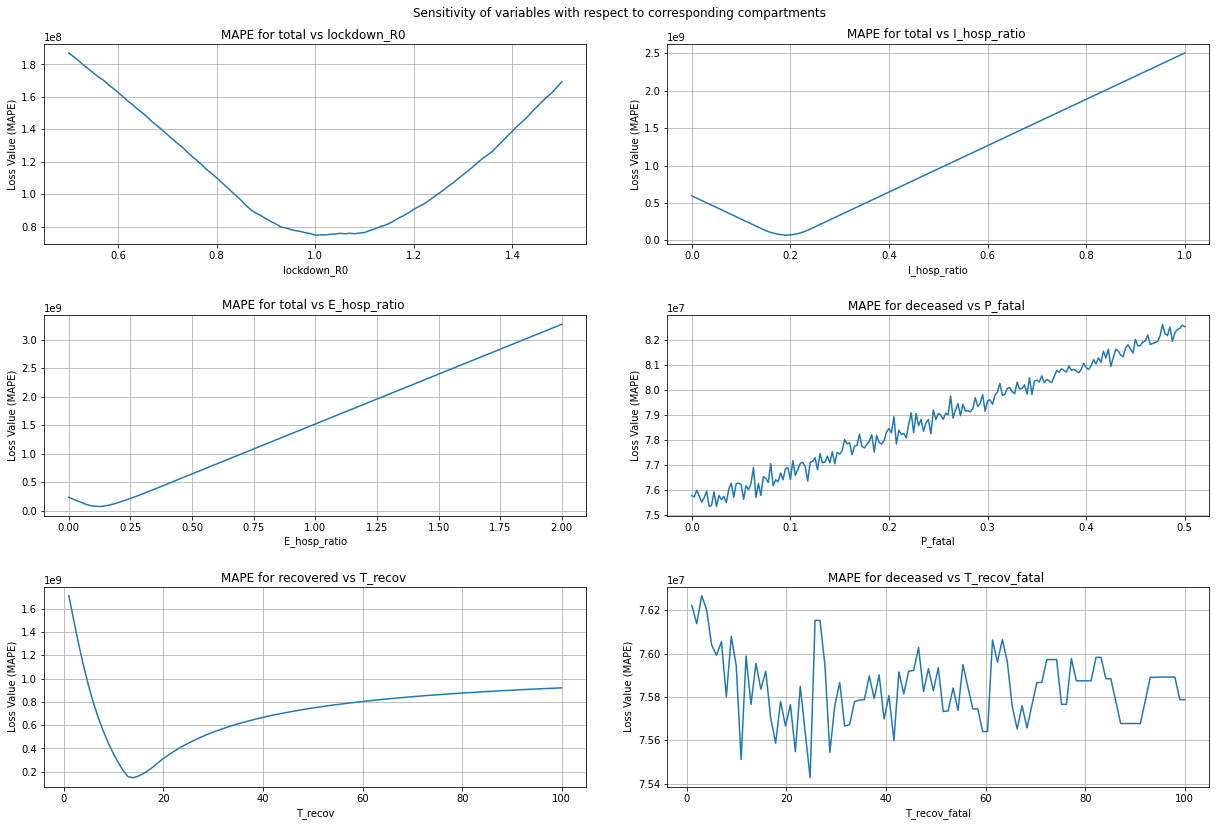

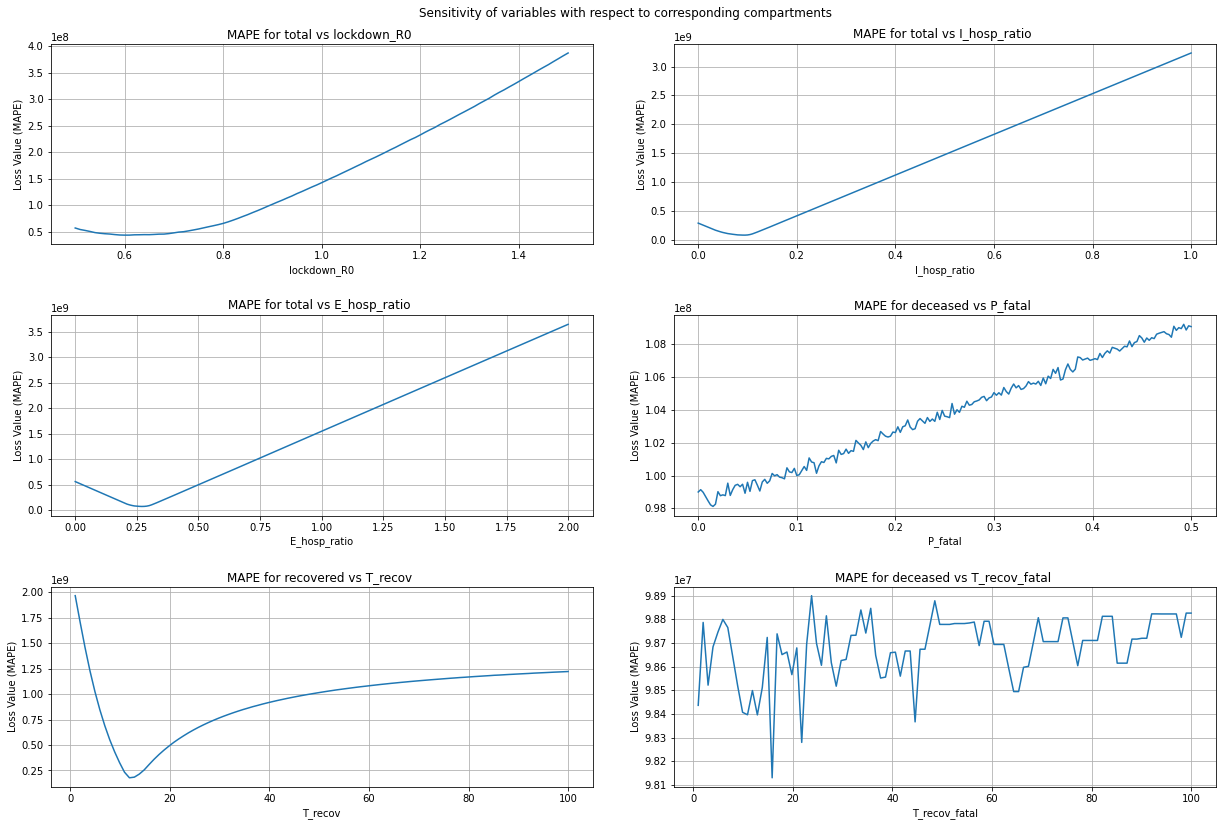

In [11]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [12]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date       S    E    I  R_recov  R_fatal      C    D  active  \
0  2020-10-02  618669  642  224     2065       18  12075  303    2083   
1  2020-10-03  618601  577  279     1965       18  12252  304    1983   
2  2020-10-04  618521  534  310     1886       18  12422  305    1904   
3  2020-10-05  618436  506  326     1820       18  12585  306    1838   
4  2020-10-06  618348  485  333     1763       18  12743  307    1781   
..        ...     ...  ...  ...      ...      ...    ...  ...     ...   
65 2020-12-06  614808  160  121      526        9  18020  351     535   
66 2020-12-07  614776  157  119      517        9  18066  352     526   
67 2020-12-08  614744  154  117      508        9  18111  352     517   
68 2020-12-09  614713  152  115      499        9  18155  353     508   
69 2020-12-10  614683  149  113      490        9  18199  353     499   

    recovered  deceased  total  
0       12075       303  14461  
1       12252       304  14539  
2       12422       305

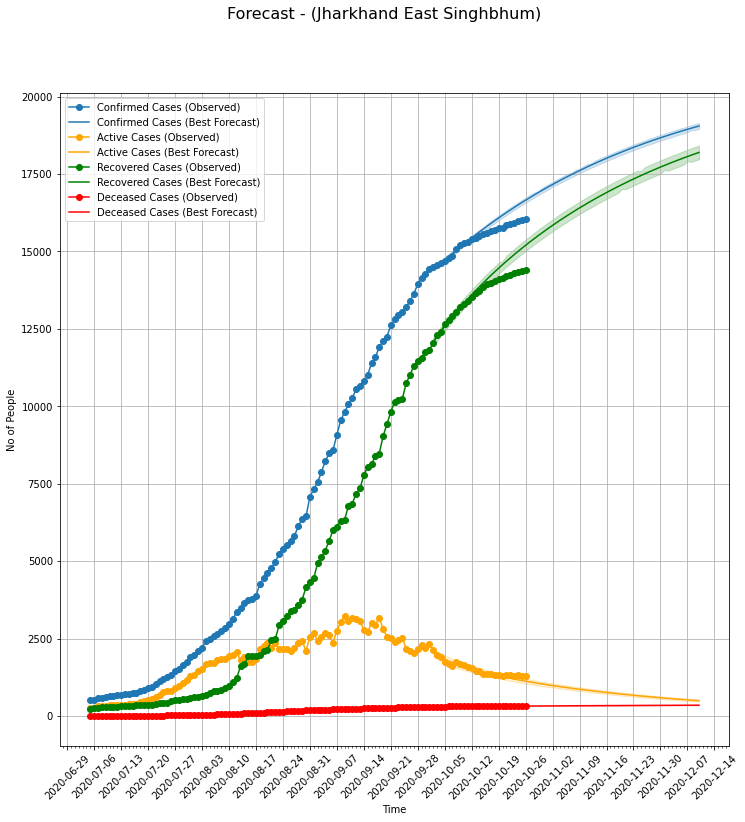

In [13]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [14]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

13it [00:00, 121.56it/s]getting forecasts ..
1000it [00:09, 106.98it/s]


In [15]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 102.05it/s]getting forecasts ..
1000it [00:09, 101.99it/s]


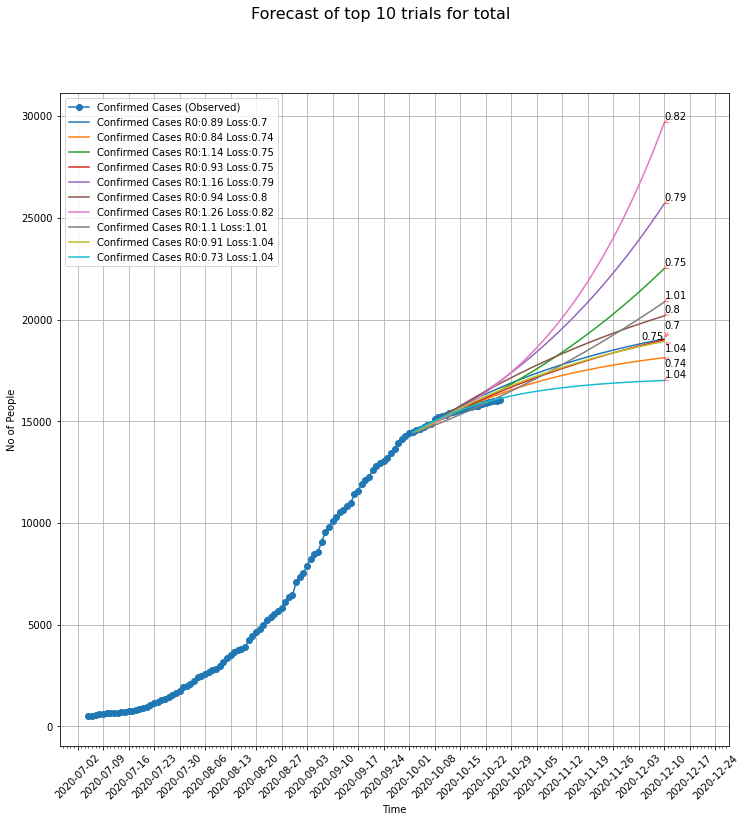

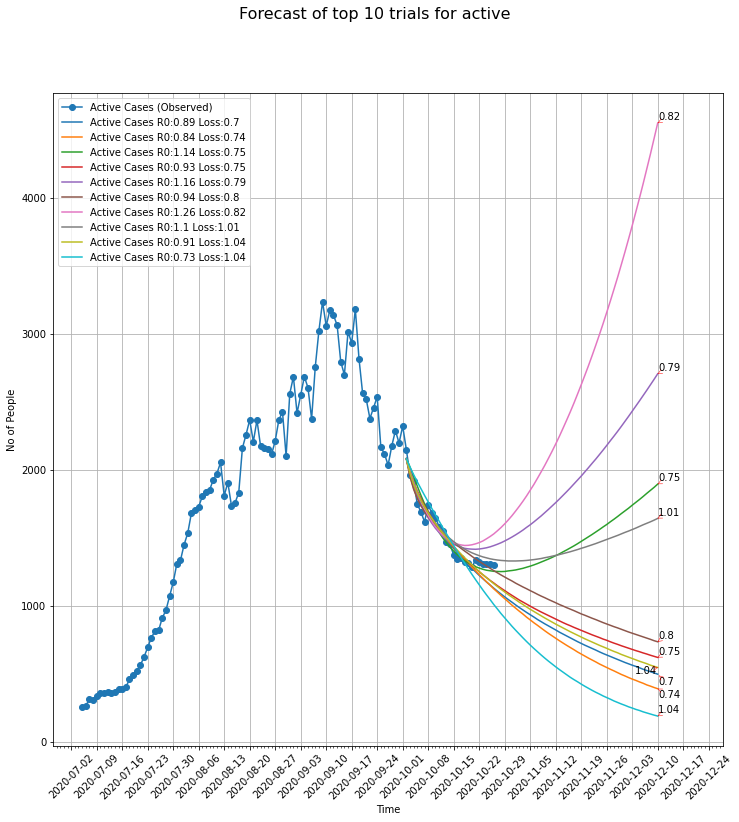

In [16]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [17]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [18]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:49<00:00,  2.02trial/s, best loss: 1.6563918093812662]


In [19]:
uncertainty.beta_loss

{'active': 1.0820378657835708,
 'recovered': 1.9490180187881143,
 'deceased': 1.8945626385883145,
 'total': 1.6999487143650653}

In [20]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [21]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

[         date       S    E    I  R_recov  R_fatal      C    D  active  \
0  2020-10-02  618669  642  224     2065       18  12075  303    2083   
1  2020-10-03  618601  577  279     1965       18  12252  304    1983   
2  2020-10-04  618521  534  310     1886       18  12422  305    1904   
3  2020-10-05  618436  506  326     1820       18  12585  306    1838   
4  2020-10-06  618348  485  333     1763       18  12743  307    1781   
..        ...     ...  ...  ...      ...      ...    ...  ...     ...   
65 2020-12-06  614808  160  121      526        9  18020  351     535   
66 2020-12-07  614776  157  119      517        9  18066  352     526   
67 2020-12-08  614744  154  117      508        9  18111  352     517   
68 2020-12-09  614713  152  115      499        9  18155  353     508   
69 2020-12-10  614683  149  113      490        9  18199  353     499   

    recovered  deceased  total  
0       12075       303  14461  
1       12252       304  14539  
2       12422       305

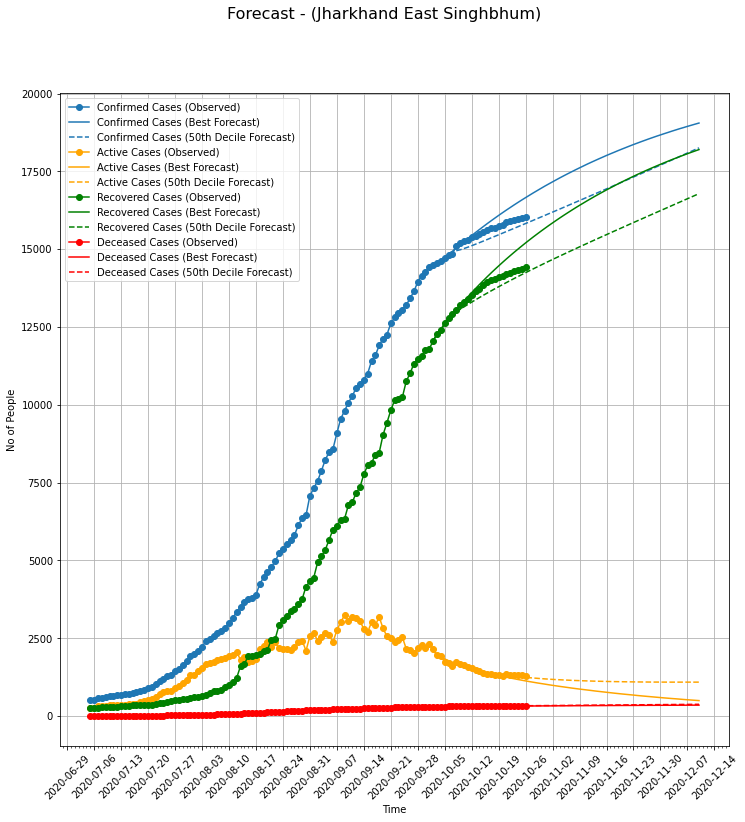

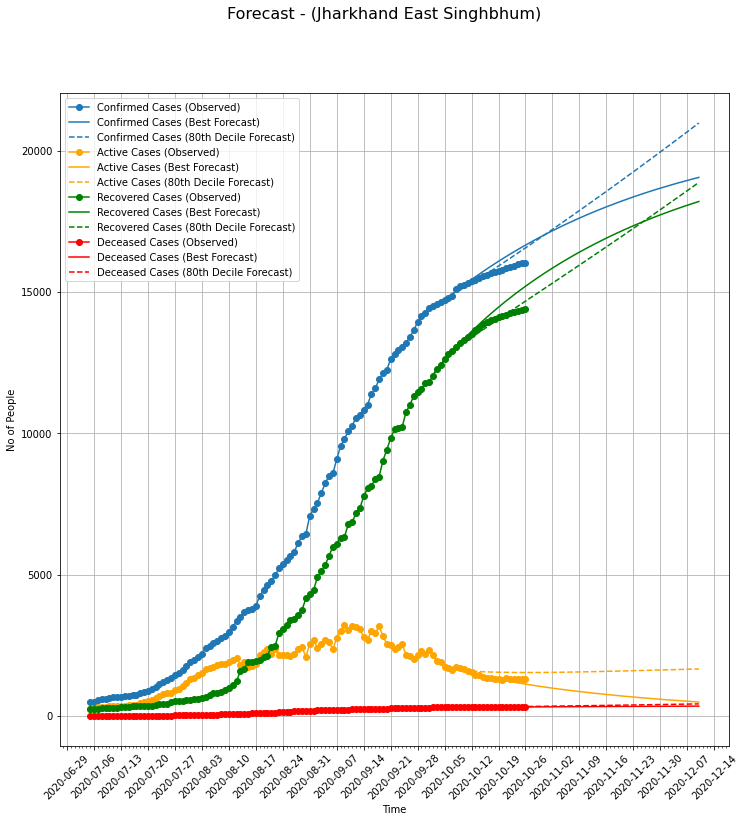

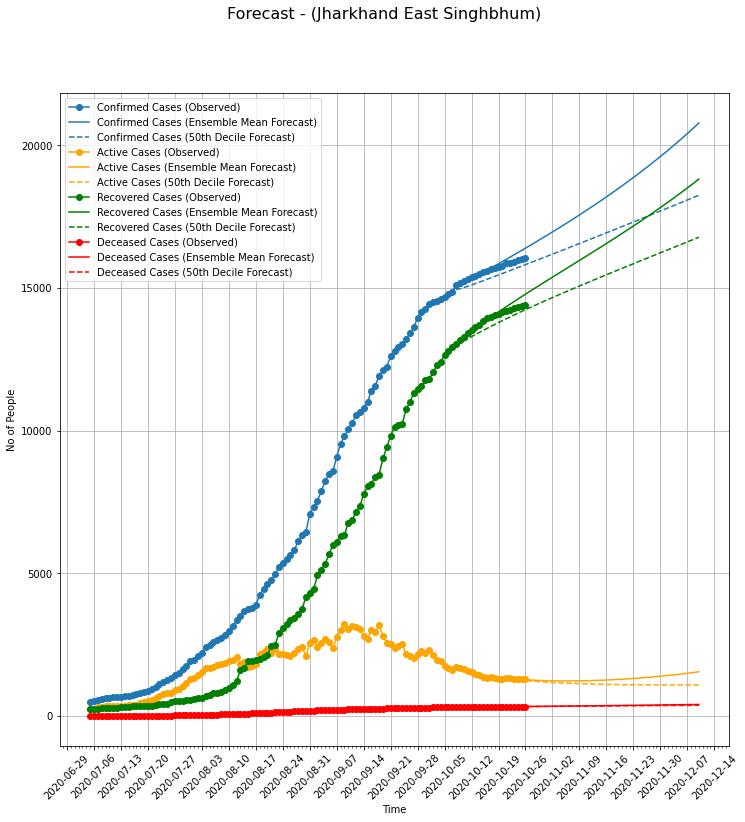

In [22]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

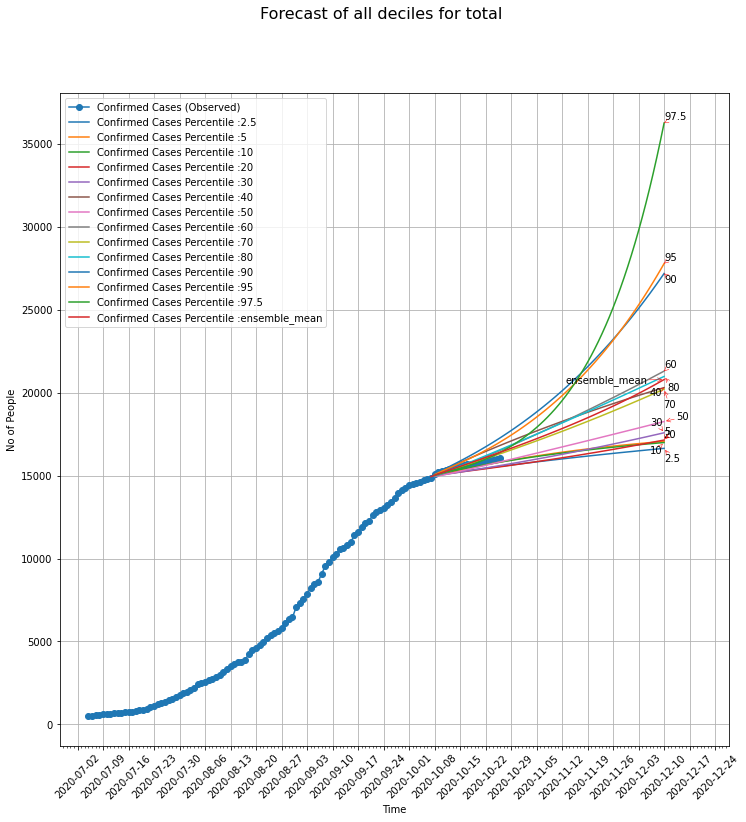

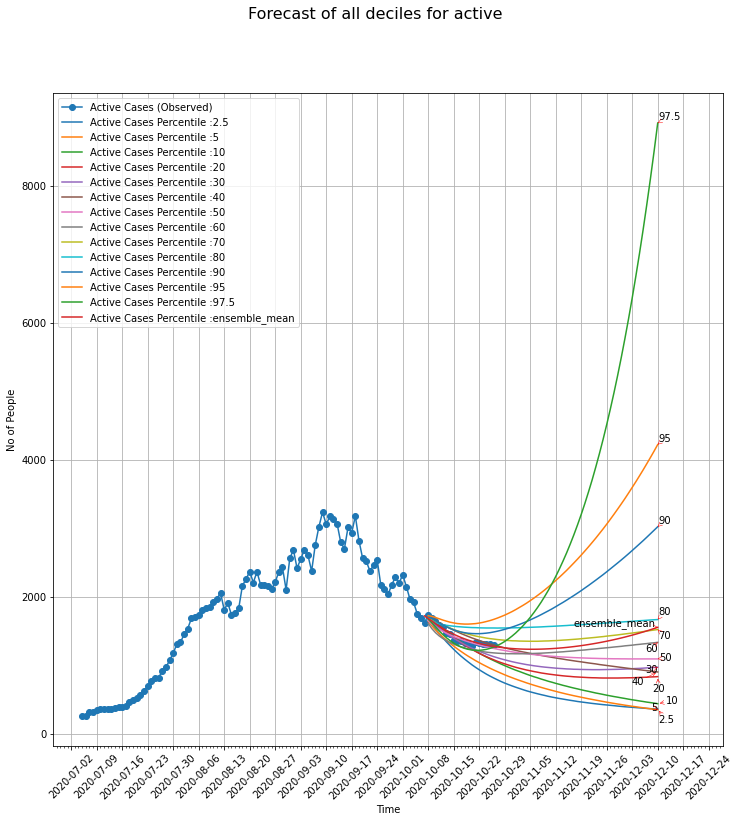

In [23]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


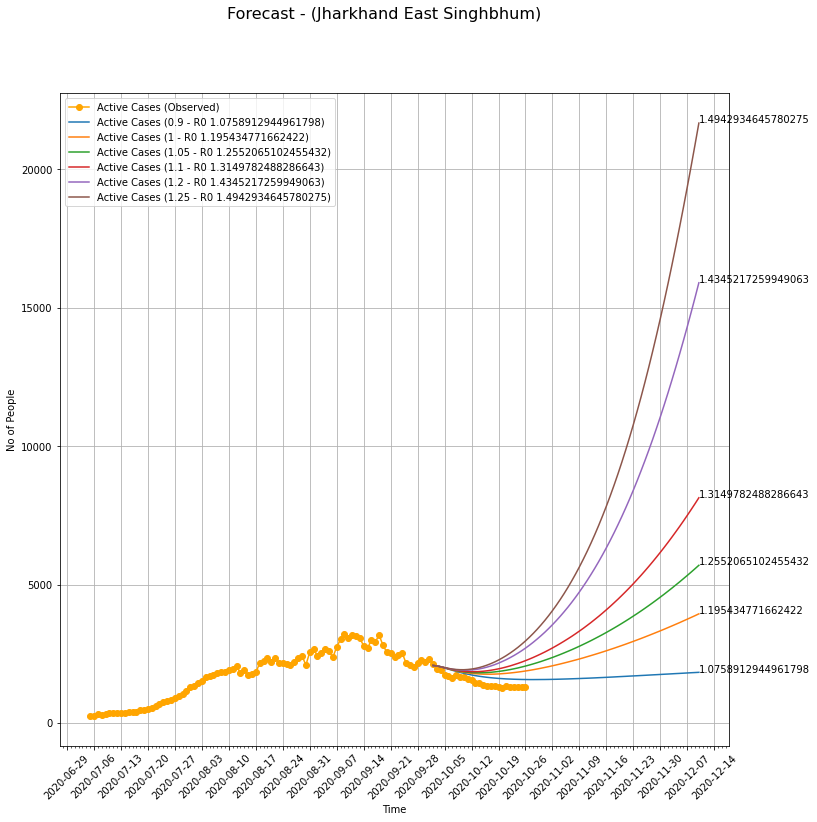

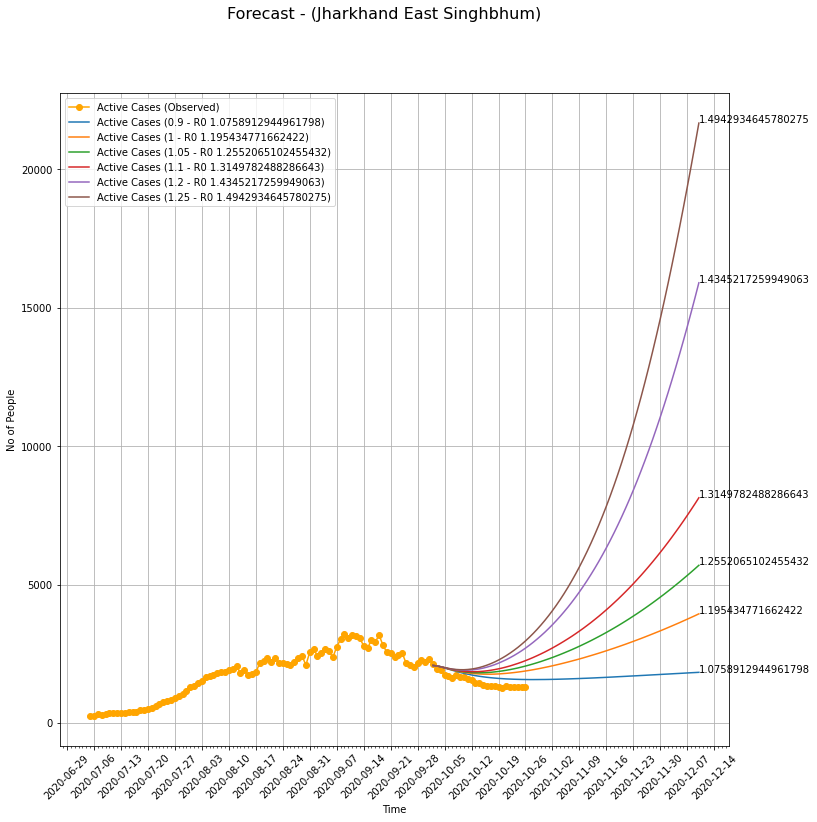

In [24]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [25]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [26]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [27]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [28]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [29]:
save_r0_mul(predictions_mul_dict, output_folder)

## Create df_district Output

In [30]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')